CoastSat outputs an array of [X,Y] UTM coordinates for our shoreline. CEM requires an [X,Y,Z] mesh. In the shorelinetogrid function we generate crossshore elevation for our grid using the Dean Profile equation (Dean, 1991): 

$$h(x) = Ax^{m}$$

where:
    <li>*h* = depth (m)</li>
    <li>*x* = cross-shore distance (m)</li> 
    <li>*A* = shape parameter (0.05 to 0.25 based on sed. characteristics, hardcoded to be 0.1)</li>
    <li>*m* = 2/3 (describes the typical concave up shape of beach slope)</li>
       
*Note that while this equation can provide a relatively accurate first cut assesment of nearshore bathymetry, it was designed for planar beaches with uniform slope (i.e., no sand bars or complicated bathymetry)*

In [1]:
import sys
sys.path.append('../scripts')  # Path relative to the notebook

import cem_utils as utils  # Now you can import it
import buoypy as bp

import numpy as np
import matplotlib.pyplot as plt
import buoypy as bp
from scipy import stats, signal
from scipy.spatial import cKDTree
#import utils

In [2]:
wave_climate = np.loadtxt('../data/cem/umpqua_wave_climate_data.txt')

Hs = wave_climate[0]
Tp = wave_climate[1]
Dir = wave_climate[2]

xy = np.loadtxt('../data/cem/coquille_pt_coords.txt')
# xy = np.loadtxt('/Users/ryan/Documents/ESPIn/CoastSat/ref_shoreline_pt_coords.txt')

# shoreline
x=xy[:,0]
y=xy[:,1]
dx=100
dy=100

# check the orentation by uncommenting the line below
# plt.plot(x,y)

In [3]:
# Stack and sort by y (column), then x (row)
sorted_indices = np.lexsort((y,x))

# Apply the sorted order
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

#plt.plot(x_sorted,y_sorted)

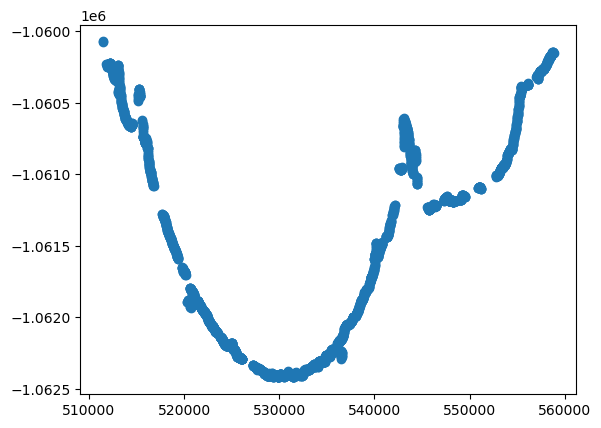

In [4]:
def rotate_shoreline(x,y,angle='auto'):
    '''This function takes points (x,y) and rotates them by an angle
    The angle is automatically generated by the end points of the shorelines coordinates
    If this approach doesnt work for some reason you may input an angle maually (in degrees).'''
    
    if angle == 'auto':
        sign = -1 if y[-1]>y[0] else 1
        a = sign*np.arctan((y[-1]-y[0])/(x[-1]-x[0]))
    else:
        a = angle*np.pi/180
    # using this roation matix
    xnew = (x ) * np.cos(a) - (y ) * np.sin(a)  
    ynew = (x ) * np.sin(a) + (y ) * np.cos(a) 
    return xnew,ynew

xnew,ynew = rotate_shoreline(x_sorted,y_sorted, -71)

plt.scatter(xnew,ynew)

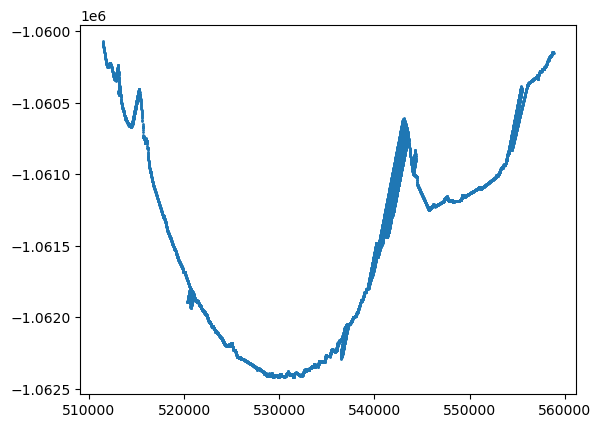

In [5]:
def fill_gaps(x, y, max_gap):
    x = np.array(x)
    y = np.array(y)
    
    x_filled = []
    y_filled = []

    for i in range(len(x) - 1):
        # Always include the current point
        x_filled.append(x[i])
        y_filled.append(y[i])

        # Compute the gap
        gap = x[i+1] - x[i]

        if gap > max_gap:
            # Number of new points to insert
            num_new = int(np.floor(gap / max_gap))

            # Generate new x values
            new_x = np.linspace(x[i], x[i+1], num=num_new+2)[1:-1]
            new_y = np.linspace(y[i], y[i+1], num=num_new+2)[1:-1]

            x_filled.extend(new_x)
            y_filled.extend(new_y)

    # Don't forget the last point
    x_filled.append(x[-1])
    y_filled.append(y[-1])

    return np.array(x_filled), np.array(y_filled)

x, y = fill_gaps(xnew, ynew, 10)

# check the orentation by uncommenting the line below
plt.scatter(x,y, s=1)

# if it isnt right, input an angle into the function above and rotate manually
# if it looks good, run the cell below

In [6]:
from matplotlib import path

def shoreline_to_grid(x, y, dx, dy, plotdata=True):
    """ function to convert xy shoreline to gridded elevation for input to CEM
        takes arrays of x and y in UTM or lat lon values. Assumes a Dean Profile.
        Will plot output unless specified plotdata=False
            """
    ##### build grid
    # find the smallest and largest x's and y's to initialize grid boundaries
    x0 = int(np.ceil(min(x) / dx) * dx) # lower left x values, rounded to 100
    y0 = int(np.ceil(min(y) / dy) * dy)
    x1 = x0 + int(np.ceil((max(x) - min(x)) / dx) * dx - 2 * dx)  # add total length of x to origin x
    y1 = y0 + int(np.ceil((max(y) - min(y)) / dy) * dy + 5000)
    # create mesh grid of x and y
    # [xg, yg] = np.meshgrid(list(range(x0, x1, dx)), list(range(y0-2000, y1, dy)), sparse=False, indexing='ij')
    [xg, yg] = np.meshgrid(np.linspace(x0, x1, dx), np.linspace(y0-2000, y1, dy), sparse=False, indexing='ij')


    return xg, yg

In [7]:
dx=100
dy=100
xg,yg = shoreline_to_grid(x,y,dx,dy)

In [8]:
def create_dean_bathy(x,y,xg,yg,pad,A=0.1,b=(2/3),beachelev=1):
    # Flatten grid points
    grid_points = np.column_stack((xg.ravel(), yg.ravel()))
    # Build KDTree from shoreline
    shoreline_points = np.column_stack((x, y)) #reshape x,y to handshake with cKDTree class
    tree = cKDTree(shoreline_points) #instantiate
    # Query the nearest shoreline point for each grid cell
    dist, _ = tree.query(grid_points) #use the query method in the cKDTree class
    # Reshape distances back to grid shape
    dist_map = dist.reshape(xg.shape)
    # Allocate storage for z array
    zg = np.zeros_like(xg)
    # Compute dean profile
    zg = A * dist_map ** b
    # Set the beach elevation
    # # smooth out to create gradient
    neighs = np.ones([10,10])
    total = (10**2)
    zg = signal.convolve2d(zg,neighs/total,mode='same',boundary='symm')

    for i in range(zg.shape[0]): #for all columns i
        # find max row index where dist_map==0
        j = np.argmin(dist_map[i, :])
        zg[i, 0:j]= -beachelev
    # Output the new bathymetry
    zg=-zg.T.copy()
    return zg, dist_map

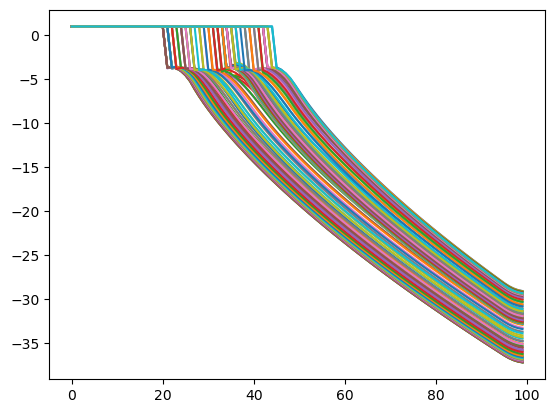

In [9]:
A=0.1 
b=(2/3)
pad=20
zg, dist_map = create_dean_bathy(x,y,xg,yg,pad,A,b)

plt.plot(zg)
plt.show()

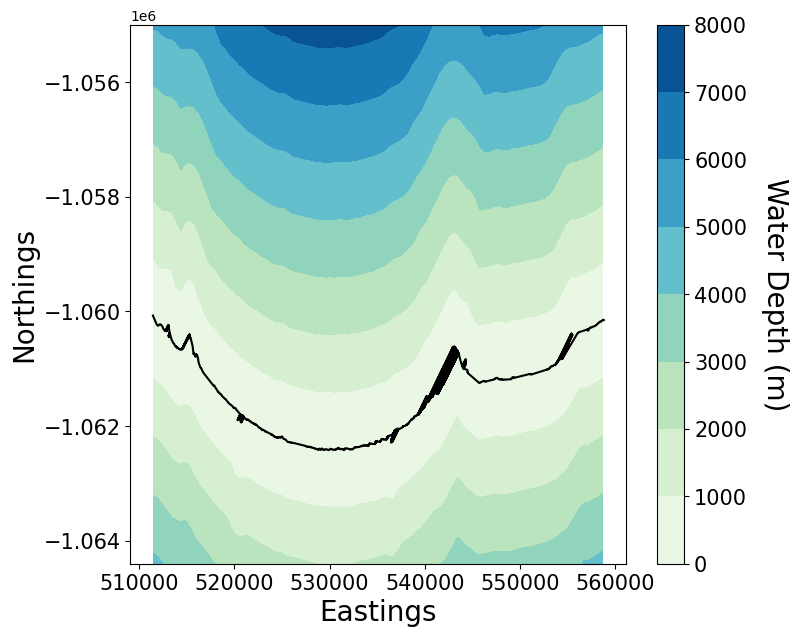

In [10]:
M,N = zg.shape
s = M/N
plt.figure(figsize=(int(s*8),7))
Bathy = plt.contourf(xg, yg, dist_map, cmap=plt.cm.GnBu)
cbar = plt.colorbar(Bathy)
cbar.ax.set_ylabel('Water Depth (m)', fontsize=20, rotation=-90, labelpad=30)
plt.xlabel('Eastings', fontsize=20)
plt.ylabel('Northings', fontsize=20)
plt.tick_params('both', labelsize=15)
cbar.ax.tick_params('y', labelsize=15)
Shore = plt.plot(x, y, 'k')

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_coast(domain,dx,dy):
    '''Plot the coastline.
    
    Inputs:
    ------
    domain = any 2D array (though colorbar label is specific for water depth)
    
    '''
    N,M = domain.shape
    s = M/N
    fig,ax = plt.subplots(figsize=(int(s*8),7))
    im = ax.imshow(domain, origin='lower', cmap='viridis')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(im,cax=cax)
    cb.ax.tick_params('both',labelsize=15)
    cb.ax.set_ylabel('Water Depth (m)',fontsize=20,rotation=-90, labelpad=30)
    y = np.linspace(0,N,4)
    x = np.linspace(0,M,4)
    Y = (y*dy/(1000)).astype('int')
    X = np.asarray(x*dx/(1000)).astype('int')
    ax.set_yticks(y)
    ax.set_xticks(x)
    ax.set_yticklabels(Y)
    ax.set_xticklabels(X)
    ax.set_xlabel('Along shore (km)',fontsize=20)
    ax.set_ylabel('Cross shore (km)',fontsize=20)
    ax.tick_params('both',labelsize=15)

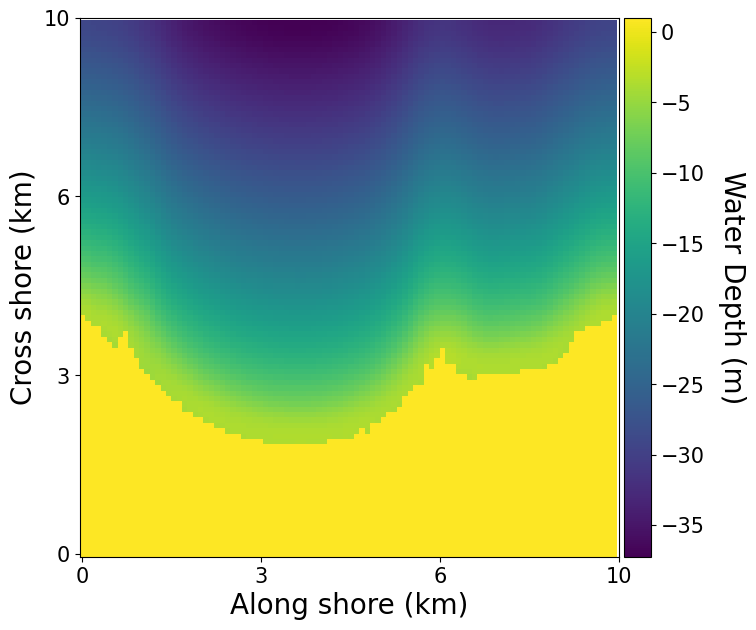

In [12]:
plot_coast(zg,dx,dy)

In [13]:
def find_shelf_slope(domain,pad=20): #same pad as above
    h = lambda x: 0.1*x**(2/3) ## depth equation
    profile = np.copy(domain)[:,0] ## find a nice straight column in the domain...
    ## whose depth gradient is towards the top of the domain
    x = np.arange(len(profile))*dx ## the off shore coords in [meters]
    ## find the shoreline edge and approximate the gradient using the equation from the previous notebook:
    x0 = x[pad] ## edge of beach--defined by the pad from previous step if that was used
    xf = x[-1] ## open ocean depth
    return (h(xf)-h(x0))/(xf-x0) 

shelf_slope = find_shelf_slope(zg) ##This should be on the order of 0.001. If not you may need to find this manually
# estimation of shoreface parameters:
shoreface_slope = -4*shelf_slope ## the shoreface is steeper than the shelf
shoreface_depth = 0 # depth meters

# Model Run

In [14]:
from pymt.models import Cem, Waves
cem = Cem()
waves = Waves()
#convert wave direction to asymmetry term
Ap = float(abs((Dir-71)-270)/180)

In [15]:
#convert wave direction to asymmetry term
params = {
    
    ## CEM 
    'grid_spacing'    : dx,                #meters
    'shelf_slope'     : shelf_slope,
    'shoreface_depth' : shoreface_depth,   #meters
    'shoreface_slope' : shoreface_slope,
    'model__time_step': 1,               #days
    
    ##WAVES
    'wave_height' : Hs, #meters
    'wave_period' : Tp, #seconds
    'wave_angle_highness': 0.35, #important param
    'wave_angle_asymmetry': Ap
    
}

In [16]:
def initialize_models(params,domain,cem,waves,set_land):
    '''
    Inputs:
    ------
    
    -params = parameter dictionary
    
    -domain = initial elevation domain
        ---> domain values in (-inifinity,1] 
                -->> 1 = land, <1 = water
                
    -cem,waves = the imported models 
        --->ex: cem = pymt.Cem()
            
    '''
    p = params
    
    N,M = domain.shape

    args = cem.setup( number_of_rows = N , number_of_cols = M, 
                  grid_spacing = p['grid_spacing'] ,  shelf_slope = p['shelf_slope'] , 
                  shoreface_depth = p['shoreface_depth'] , shoreface_slope = p['shoreface_slope']
                )

    waves.initialize(*waves.setup())
    cem.initialize(*args)
    
    waves.set_value('sea_surface_water_wave__height', p['wave_height']);
    waves.set_value('sea_surface_water_wave__period',p['wave_period']);
    waves.set_value('sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_highness_parameter',
                   p['wave_angle_highness']);
    waves.set_value('sea_shoreline_wave~incoming~deepwater__ashton_et_al_approach_angle_asymmetry_parameter',
                   p['wave_angle_asymmetry']);

    if set_land==True: #if need set land elevation; 'False' used default
        cem.set_value('land_surface__elevation',domain.flatten());
    cem.set_value('model__time_step', float(p['model__time_step']));

Condition Initial 


Setting end time to 3650
CEM: trying to open file: cem.txt
CEM: line: 100, 100, 100, 1

CEM: number of rows, columns: 100, 100
*** Grid size is (0,0)
*** Requested size is (100,200)
*** New grid size is (100,200)


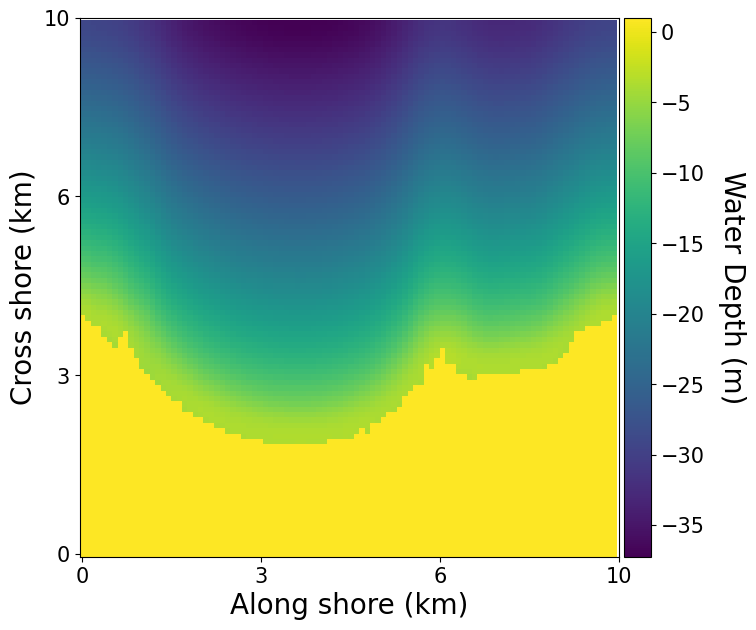

In [17]:
domain = zg
initialize_models(params,domain,cem,waves,set_land=True)
land = cem.get_value('land_surface__elevation')
land = land.reshape(  domain.shape  )
#plot_coast(domain,dx,dy)
plot_coast(land,dx,dy)

# Add Sediment

/var/folders/kr/t52nlmpn6n38qycgmd0q087c0000gn/T/ipykernel_70121/1541944257.py:5: DeprecationWarning: Call to deprecated method get_var_units. (use var_units)
  cem.get_var_units("land_surface_water_sediment~bedload__mass_flow_rate")


'kg / s'

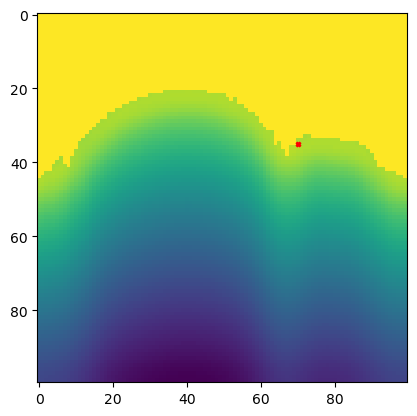

In [18]:
qs = np.zeros_like(land)
qs[35, 70] = 100
plt.imshow(land)
plt.scatter(70, 35, c='r', s=10, marker='X')
cem.get_var_units("land_surface_water_sediment~bedload__mass_flow_rate")

UnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillUnderzerofillLoner fixbeach breakdown - mass disintegrated x: 25  y: 75
@@@ Didn't find anywhere to steal sand from!! x: 25  y: 152

Paused x: 25  y: 152 Time: 0
UnderzerofillUnderzerofillLoner fixbeach breakdown - mass disintegrated x: 25  y: 175
UnderzerofillUnderzerofillUnderzerofi

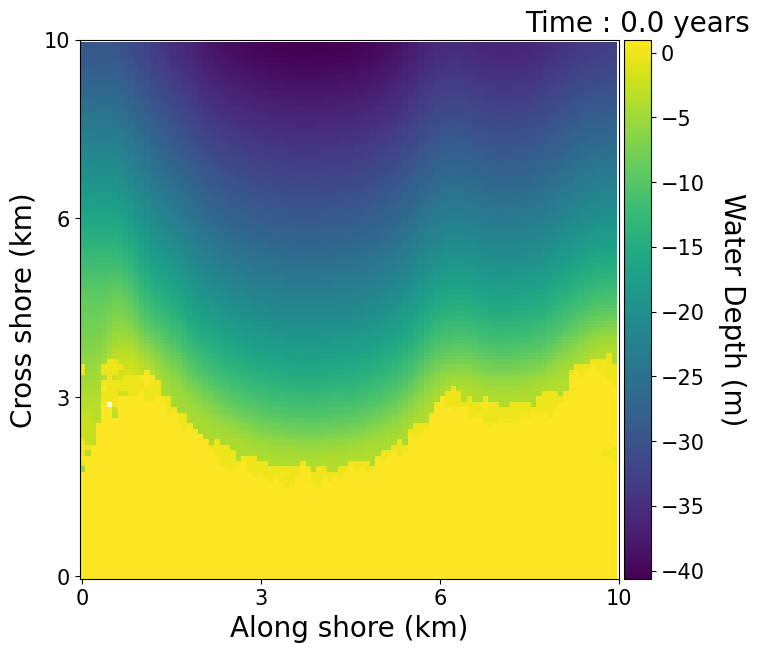

In [ ]:
from IPython.display import clear_output

def run_model_loop(time_years, domain ,cem ,waves, qs_3,animate,update_ani_years):
    '''Loop to run the cem-waves models.
    This loop only couples the wave angles and will need to be changed to add additional coupling.
    It also assumes static variables such as sediment input and would need modification to update such variables.
    
    Inputs:
    ------
    
    -time_years = time you want to run the model in years
    
    -domain = initial elevation domain
        ---> domain values in (-inifinity,1] 
                -->> 1 = land, <1 = water
                
    -cem,waves = the imported models 
        --->ex: cem = pymt.Cem()
        
    '''

    alpha = 'sea_surface_water_wave__azimuth_angle_of_opposite_of_phase_velocity'
    update_ani = int(365*update_ani_years/cem.get_value('model__time_step'))
    T = int(365*time_years/cem.get_value('model__time_step'))
    dx,dy = cem.grid_spacing(cem.var_grid('sea_water__depth'))
    for time in range(T):
        waves.update()
        angle = waves.get_value(alpha)
        cem.set_value(alpha, angle)
        cem.set_value("land_surface_water_sediment~bedload__mass_flow_rate", np.array(qs_3[:,:,time]))
        cem.update()
        if animate:
            if time%update_ani == 0 or time==T-1:
                clear_output(wait=True)
                plot_coast(cem.get_value('land_surface__elevation').reshape(domain.shape),dx,dy)
                plt.title('Time : '+ str(round((time*cem.get_value('model__time_step')/365)[0],1)) +' years',fontsize=20)
                plt.show()

        else:
            clear_output(wait=True)
            print('Time Step: ',time, ' days')


time_years=20
T = int(365*time_years/cem.get_value('model__time_step'))
qs_vec = np.linspace(4,7,T)
n,m = domain.shape
qs_3 = np.zeros((n,m,T))
qs_3[35,70,:] = qs_vec
run_model_loop(time_years, domain ,cem ,waves, qs_3,animate=True,update_ani_years=1)

In [ ]:
def extract_raster_shoreline(land):
    gradx, grady = np.gradient(land)
    G = np.sqrt(gradx**2 + grady**2)

    # Binary mask for land
    landbin = np.zeros_like(land)
    landbin[land > 0] = 1

    # Newline where gradient > 0 and landbin == 1
    shoreline_map = np.zeros_like(land)
    shoreline_map[(G > 0) & (landbin == 1)] = 1
    return shoreline_map

In [ ]:
def extract_vector_shoreline(land,window=1):
    gradx, grady = np.gradient(land)
    G = np.sqrt(gradx**2 + grady**2)

    # Binary mask for land
    landbin = np.zeros_like(land)
    landbin[land > 0] = 1

    # Newline where gradient > 0 and landbin == 1
    shoreline_map = np.zeros_like(land)
    shoreline_map[(G > 0) & (landbin == 1)] = 1

    xinds,yinds = np.where(shoreline_map==1)

    yinds,xinds = np.nonzero(shoreline_map)
    shoreline_x = xg[xinds,yinds]
    shoreline_y = yg[xinds,yinds]

    # Stack and sort by y (column), then x (row)
    sorted_indices = np.lexsort((shoreline_y, shoreline_x))

    # Apply the sorted order
    x_sorted = shoreline_x[sorted_indices]
    y_sorted = shoreline_y[sorted_indices]

    # Spline fit (not working right now?)
    # from scipy.interpolate import UnivariateSpline
    # spline = UnivariateSpline(x_sorted, y_sorted, s=window)  # `s` is the smoothing factor
    # y_smooth = spline(x_sorted)
    
    return x_sorted,y_sorted

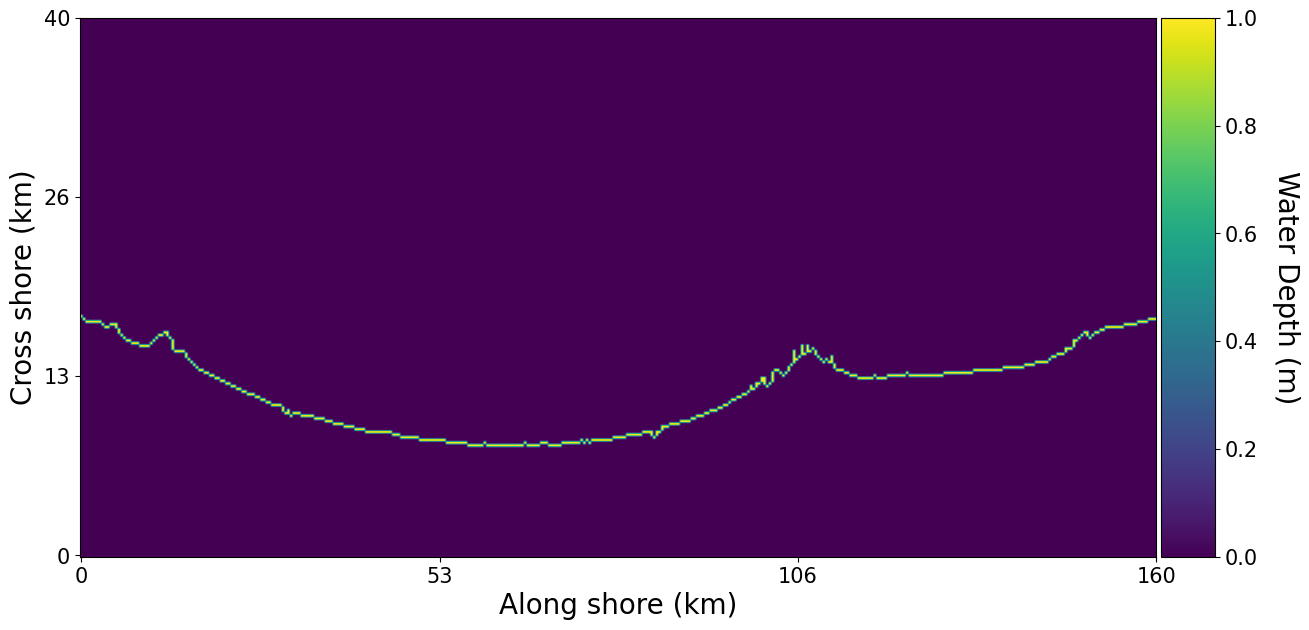

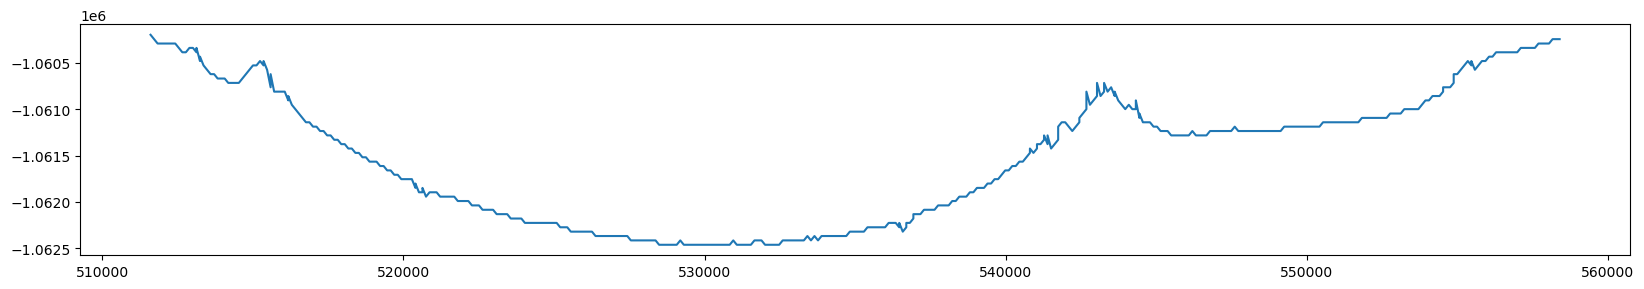

In [ ]:
shoremap = extract_raster_shoreline(land)
plot_coast(shoremap,dx,dy)

xline, yline = extract_vector_shoreline(land)
plt.figure(figsize=(20,3));
plt.plot(xline,yline)